In [6]:
import os
import cv2
import torch
from PIL import Image
import requests
import yaml
import subprocess
import matplotlib.pyplot as plt
import glob

In [53]:
torch.cuda.is_available()

True

In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone
!cd yolov5
!pip install -r requirements.txt

!pip install ultralytics

Cloning into 'yolov5'...
remote: Enumerating objects: 16680, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (158/158), done.
remote: Total 16680 (delta 101), reused 129 (delta 63), pack-reused 16459
Receiving objects: 100% (16680/16680), 15.33 MiB | 31.02 MiB/s, done.
Resolving deltas: 100% (11407/11407), done.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 656.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.6/793.6 kB 5.6 MB/s eta 0:00:0000:0100:01


In [4]:
# parameters
TRAIN = True
EPOCHS = 25
# RES_DIR = "output\\results"
RES_DIR = "/kaggle/working/"
ROOT_DIR = "/kaggle/input/helmet828/data"


In [7]:
config = {
   "train": ROOT_DIR + "/train/images",
   "val": ROOT_DIR + "/val/images",
   "nc": 2,
   "names": ['helmet','no_helmet']
}

with open("data.yaml", "w") as file:
   yaml.dump(config, file, default_flow_style=False)


In [57]:
!cat data.yaml

names:
- helmet
- no_helmet
nc: 2
train: /kaggle/input/helmet626/data/train/images
val: /kaggle/input/helmet626/data/val/images


In [8]:
!wandb disabled


W&B disabled.


In [59]:
# from ultralytics import YOLO
# model = YOLO("yolov5s.yaml")  # Build a new model from scratch


In [60]:
# freeze = [f"model.{x}." for x in range(10)]  
# for k, v in model.named_parameters():
#     v.requires_grad = True 
#     if any(x in k for x in freeze):
#         print(f"freezing {k}")
#         v.requires_grad = False
        
# for k, v in model.named_parameters():
#     print(k)


In [61]:
# model.train(data='data.yaml', epochs=3, batch=16, imgsz=800, device=0)

In [62]:
def plot_labels(img_path, lab_path):
    # Read the image
    img = cv2.imread(img_path)
    img_height, img_width, _ = img.shape
    
    # Read the labels
    with open(lab_path, 'r') as file:
        lines = file.readlines()
    
    for line in lines:
        elements = line.strip().split()
        class_id = int(elements[0])
        x_center = float(elements[1])
        y_center = float(elements[2])
        width = float(elements[3])
        height = float(elements[4])
        
        # Convert normalized coordinates to pixel values
        x_center_pixel = int(x_center * img_width)
        y_center_pixel = int(y_center * img_height)
        width_pixel = int(width * img_width)
        height_pixel = int(height * img_height)
        
        # Calculate the top-left corner of the bounding box
        x1 = int(x_center_pixel - width_pixel / 2)
        y1 = int(y_center_pixel - height_pixel / 2)
        x2 = int(x_center_pixel + width_pixel / 2)
        y2 = int(y_center_pixel + height_pixel / 2)
        
        # Draw the bounding box
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        # Put the label
        cv2.putText(img, str(class_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    
    # Convert BGR image to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

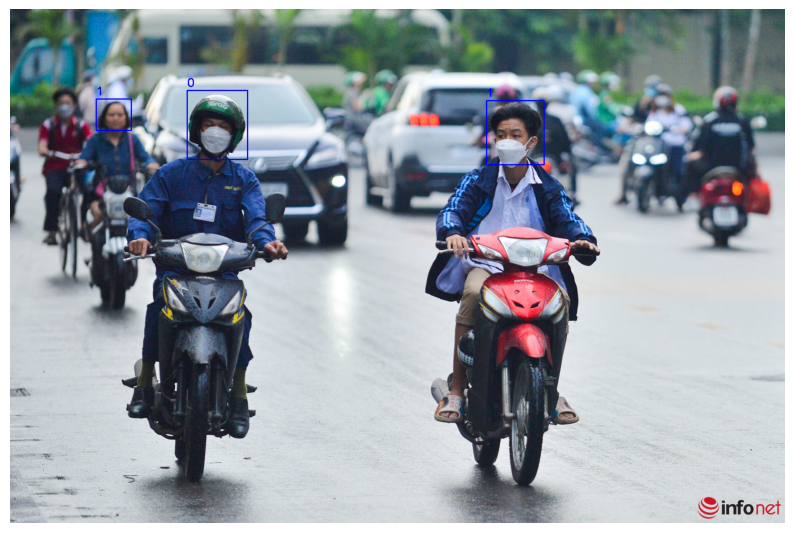

In [63]:
image = '/kaggle/input/helmet-800/data/train/images/1.png'
label = '/kaggle/input/helmet-800/data/train/labels/1.txt'

plot_labels(image, label)

In [64]:
def fitness(x):
    w = [0.0, 0.0, 0.1, 0.9]  # weights for [P, R, mAP@0.5, mAP@0.5:0.95]
    return (x[:, :4] * w).sum(1)

In [ ]:
!python yolov5/train.py --img 1280 --epochs 25 --data data.yaml --batch 16 --cfg yolov5s.yaml --device 0,1
# !python yolov5/train.py --img 1280 --epochs 25 --data data.yaml --batch 16 --cfg yolov5s.yaml --evolve 20 --device 0,1


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-06-28 02:16:00.452794: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-28 02:16:00.452857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-28 02:16:00.454388: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5/yolov5s.pt, cfg=yolov5s.yaml, data=data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=25, batch_size=16, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, no

In [ ]:
import warnings
warnings.filterwarnings('ignore')


In [28]:
content = """

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [16,16, 22,24, 32,34] # P3/8
  - [46,48, 77,84, 118,134] # P4/16
  - [216,224, 296,342, 526,593] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # cat backbone P3
    [-1, 3, C3, [256, False]], # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]], # cat head P4
    [-1, 3, C3, [512, False]], # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]], # cat head P5
    [-1, 3, C3, [1024, False]], # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]], # Detect(P3, P4, P5)
  ]
"""


with open('yolov5s.yaml', 'w') as file:
    file.write(content)

content = """

lr0: 0.01
lrf: 0.01
momentum: 0.937
weight_decay: 0.0005
warmup_epochs: 3.0
warmup_momentum: 0.8
warmup_bias_lr: 0.1
box: 0.05
cls: 0.5
cls_pw: 1.0
obj: 1.0
obj_pw: 1.0
iou_t: 0.2
anchor_t: 4.0
fl_gamma: 0.0
hsv_h: 0.01041
hsv_s: 0.54703
hsv_v: 0.27739
degrees: 0.0
translate: 0.04591
scale: 0.75544
shear: 0.0
perspective: 0.0
flipud: 0.0
fliplr: 0.5
mosaic: 0.85834
mixup: 0.04266
copy_paste: 0.0

"""


with open('hyp_evolve.yaml', 'w') as file:
    file.write(content)

In [ ]:
!cat yolov5/runs/evolve/exp/hyp_evolve.yaml

In [29]:
!python yolov5/train.py --img 1280 --epochs 25 --data data.yaml --batch 16 --cfg yolov5s.yaml --hyp hyp_evolve.yaml --device 0,1


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-06-27 17:53:25.348370: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 17:53:25.348434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 17:53:25.349957: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5/yolov5s.pt, cfg=yolov5s.yaml, data=data.yaml, hyp=hyp_evolve.yaml, epochs=25, batch_size=16, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, nopl

In [20]:
!python yolov5/train.py --img 1280 --epochs 25 --data data.yaml --batch 16 --cfg yolov5s.yaml --device 0,1


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-06-27 17:33:03.402205: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-27 17:33:03.402266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-27 17:33:03.403896: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5/yolov5s.pt, cfg=yolov5s.yaml, data=data.yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=25, batch_size=16, imgsz=1280, rect=False, resume=False, nosave=False, noval=False, no

In [16]:
for dirname, _, filenames in os.walk('/kaggle/working/runs'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [21]:
from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

Image(filename='/kaggle/working/runs/detect/train/F1_curve.png', width=600)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/runs/detect/train/F1_curve.png'

In [ ]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/working/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [ ]:
Image(filename='/kaggle/working/runs/detect/train/val_batch0_labels.jpg', width=1000)


In [ ]:
Image(filename='/kaggle/working/runs/detect/train/val_batch0_pred.jpg', width=1000)


In [22]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))
    
    

In [30]:
!zip -r file.zip "/kaggle/working/yolov5/runs/train/exp3"

  adding: kaggle/working/yolov5/runs/train/exp3/ (stored 0%)
  adding: kaggle/working/yolov5/runs/train/exp3/val_batch1_pred.jpg (deflated 8%)
  adding: kaggle/working/yolov5/runs/train/exp3/labels.jpg (deflated 31%)
  adding: kaggle/working/yolov5/runs/train/exp3/train_batch1.jpg (deflated 6%)
  adding: kaggle/working/yolov5/runs/train/exp3/labels_correlogram.jpg (deflated 43%)
  adding: kaggle/working/yolov5/runs/train/exp3/hyp.yaml (deflated 43%)
  adding: kaggle/working/yolov5/runs/train/exp3/results.csv (deflated 82%)
  adding: kaggle/working/yolov5/runs/train/exp3/val_batch2_labels.jpg (deflated 6%)
  adding: kaggle/working/yolov5/runs/train/exp3/train_batch0.jpg (deflated 3%)
  adding: kaggle/working/yolov5/runs/train/exp3/weights/ (stored 0%)
  adding: kaggle/working/yolov5/runs/train/exp3/weights/last.pt (deflated 12%)
  adding: kaggle/working/yolov5/runs/train/exp3/weights/best.pt (deflated 12%)
  adding: kaggle/working/yolov5/runs/train/exp3/F1_curve.png (deflated 13%)
  add

In [33]:
download_file("/kaggle/working/yolov5/runs/train/exp3", "train3_result")

/kaggle/working/train3_result.zip

In [43]:
!python yolov5/detect.py --weights yolov5/runs/train/exp3/weights/best.pt --img 1280 --source /kaggle/input/helmet-800/data/test/images


detect: weights=['yolov5/runs/train/exp3/weights/best.pt'], source=/kaggle/input/helmet-800/data/test/images, data=yolov5/data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-331-gab364c98 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/83 /kaggle/input/helmet-800/data/test/images/002eb035336915e43bd081892d1b0482.jpg: 864x1280 2 helmets, 1 no_helmet, 53.4ms
image 2/83 /kaggle/input/helmet-800/data/test/images/10.png: 960x1280 4 no_helmets, 54.7ms
image 3/83 /kaggle/input/helmet-800/data/test/images/111.png: 864

In [ ]:
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()


show_valid_results(RES_DIR)

In [ ]:
def inference(RES_DIR, data_path):
    # dir to store inference results
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # inference on images
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt --source {data_path} --name {INFER_DIR}
    return INFER_DIR




In [ ]:
def visualize(INFER_DIR):

    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()


IMAGE_INFER_DIR = inference(RES_DIR, 'inference_images')
visualize(IMAGE_INFER_DIR)